In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [24]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")

products.drop(columns=['Price'], inplace=True)
df = transactions.merge(products, on='ProductID', how='left')
df = df.merge(customers, on='CustomerID', how='left')
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,ProductName,Category,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving Bluetooth Speaker,Electronics,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving Bluetooth Speaker,Electronics,Timothy Perez,Europe,2022-03-15


In [25]:
customer_features = df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'Category': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
    'Region': 'first'
}).rename(columns={'TotalValue': 'Total_Spend', 'TransactionID': 'Transaction_Count'})

customer_features.head()

,Total_Spend,Transaction_Count,Category,Region
CustomerID,,,,
C0001,3354.52,5,Electronics,South America
C0002,1862.74,4,Clothing,Asia
C0003,2725.38,4,Home Decor,South America
C0004,5354.88,8,Books,South America
C0005,2034.24,3,Electronics,Asia


In [26]:
# One-hot encode categorical features
encoder = OneHotEncoder()
categorical_features = encoder.fit_transform(customer_features[['Category', 'Region']]).toarray()
categorical_df = pd.DataFrame(categorical_features, columns=encoder.get_feature_names_out())

# Normalize numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(customer_features[['Total_Spend', 'Transaction_Count']])
numerical_df = pd.DataFrame(numerical_features, columns=['Total_Spend', 'Transaction_Count'])

final_features = pd.concat([numerical_df, categorical_df], axis=1)
final_features.head()

,Total_Spend,Transaction_Count,Category_Books,Category_Clothing,Category_Electronics,Category_Home Decor,Region_Asia,Region_Europe,Region_North America,Region_South America
0,-0.061701,-0.011458,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.877744,-0.467494,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.405857,-0.467494,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.032547,1.356650,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.783929,-0.923530,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [31]:
# Find best eps using Silhouette Score
eps_values = np.arange(0.1, 5.0, 0.1)
best_eps = 0
best_score = -1
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(final_features)
    if len(set(labels)) > 1:  # Avoid cases where all points are in one cluster
        score = silhouette_score(final_features, labels)
        if score > best_score:
            best_score = score
            best_eps = eps

print(f"Best epsilon value: {best_eps} with Silhouette Score: {best_score}")




Best epsilon value: 1.8000000000000003 with Silhouette Score: 0.4638941915191872


In [32]:
# Apply DBSCAN with best epsilon
dbscan = DBSCAN(eps=best_eps, min_samples=5)
customer_features['Cluster'] = dbscan.fit_predict(final_features)

# Compute Davies-Bouldin Index if more than one cluster exists
if len(set(customer_features['Cluster'])) > 1:
    db_index = davies_bouldin_score(final_features, customer_features['Cluster'])
    print(f"Davies-Bouldin Index: {db_index}")
else:
    print("Only one cluster found, DB Index not computed.")

Davies-Bouldin Index: 0.3730304461305967


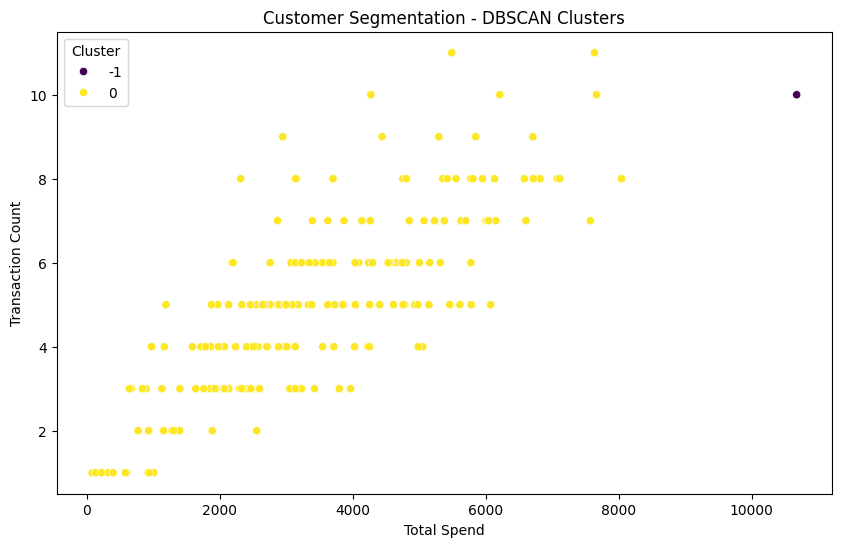

In [33]:
# Save customer cluster assignments
customer_features[['Cluster']].to_csv("Customer_Clusters_DBSCAN.csv")

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_features['Total_Spend'], y=customer_features['Transaction_Count'], hue=customer_features['Cluster'], palette='viridis')
plt.title("Customer Segmentation - DBSCAN Clusters")
plt.xlabel("Total Spend")
plt.ylabel("Transaction Count")
plt.show()